# Задача
Необходимо создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. Для оценки использовать метрику MAPE 

В данном ноутбуке мы собрали в датасет все спарсенные файлы, провели разведывательный анализ данных и кодировку. На выходе получили готовый для обучения датасет.

# Загрузка и предподготовка данных

In [1]:
#Импорт библиотек
import os
import numpy as np 
import pandas as pd
from pandas import Series
from itertools import combinations
from scipy.stats import ttest_ind

import re
import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif, f_classif

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Импорт данных из соревнования

data_test = pd.read_csv('test.csv')
data_sample = pd.read_csv('sample_submission.csv')


#Импорт своих данных

data_train = pd.DataFrame()
for dirname, _, filenames in os.walk('data'):
    
    for filename in filenames:
        try:
            df = pd.read_csv(os.path.join(dirname, filename))        
            data_train = data_train.append(df, ignore_index = True)
        except:
            df = pd.read_csv(os.path.join(dirname, filename),sep=';')        
            data_train = data_train.append(df, ignore_index = True)
            
print(len(data_train))

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


284632


Удалим дубликаты и пустые строки из спарсенных данных

In [3]:
data_train = data_train.drop_duplicates(subset=['sell_id'])
data_train = data_train.dropna(how='all')
len(data_train)

229669

In [4]:
#посмотрим какие колонки из data_train есть в data_test

#создадим пустой список, в который добавим колонки data_train, присутствующие в data_test
in_test = []
#создадим пустой список, в который добавим колонки data_train, отсутствующие в data_test
not_in_test = []

for column in data_train.columns:
    if column in data_test.columns:
        in_test.append(column)
    else:
        not_in_test.append(column)

Посмотрим на колонки data_train, присутствующие в data_test

In [5]:
in_test

['parsing_unixtime',
 'sell_id',
 'car_url',
 'description',
 'image',
 'bodyType',
 'color',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'productionDate',
 'vehicleTransmission',
 'Владельцы',
 'ПТС',
 'Привод',
 'Руль',
 'Состояние',
 'Таможня',
 'brand',
 'model_name',
 'name',
 'equipment_dict']

Посмотрим на колонки data_train, отсутствующие в data_test¶

In [6]:
not_in_test

['datetime',
 'card',
 'region',
 'sellerName',
 'price',
 'engine',
 'card_type',
 'model_name2',
 'public_date',
 'nview',
 'model_name_full',
 'confDict',
 'dealerName']

Удалим из data_train колонки, отсутствующие в data_test, кроме price

In [7]:
columns_to_drop = not_in_test[:4] + not_in_test[5:]

In [8]:
data_train = data_train.drop(columns_to_drop, axis = 1)
data_train.head(3)

,parsing_unixtime,sell_id,car_url,price,description,image,bodyType,color,engineDisplacement,enginePower,...,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,brand,model_name,name,equipment_dict
0,1.618564e+09,№ 1102441188,https://auto.ru/cars/used/sale/audi/a6/1102441...,545 000 ₽,Автомобиль в хорошем состояний. Комплектация: ...,https://avatars.mds.yandex.net/get-autoru-vos/...,седан,чёрный,3.0 л,218 л.с.,...,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,Audi,A6,3.0 AT (218 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi..."
1,1.618564e+09,№ 1102877415,https://auto.ru/cars/used/sale/audi/q7/1102877...,1 470 000 ₽,"Автомобиль в комплектации SLine, был в одной с...",https://autoru.naydex.net/1VPv37h28/4b1e74OtTr...,внедорожник 5 дв.,чёрный,4.1 л,326 л.с.,...,2 владельца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,Audi,Q7,4.1d AT (326 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi..."
2,1.618564e+09,№ 1103078155,https://auto.ru/cars/used/sale/audi/q5/1103078...,1 830 000 ₽,Машина в идеальном состоянииПолностью в родной...,https://autoru.naydex.net/1VPv37h28/4b1e74OtTr...,внедорожник 5 дв.,красный,2.0 л,225 л.с.,...,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,Audi,Q5,2.0 AT (225 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi..."


Перезапишем data_test с теми колонками, которые есть и в data_train, и в data_test

In [9]:
data_test = data_test[in_test]
data_test.head(3)

,parsing_unixtime,sell_id,car_url,description,image,bodyType,color,engineDisplacement,enginePower,fuelType,...,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,brand,model_name,name,equipment_dict
0,1603226273,1100575026,https://auto.ru/cars/used/sale/skoda/octavia/1...,"Все автомобили, представленные в продаже, прох...",https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,лифтбек,синий,1.2 LTR,105 N12,бензин,...,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,SKODA,OCTAVIA,1.2 AMT (105 л.с.),"{""engine-proof"":true,""tinted-glass"":true,""airb..."
1,1603226277,1100549428,https://auto.ru/cars/used/sale/skoda/octavia/1...,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,лифтбек,чёрный,1.6 LTR,110 N12,бензин,...,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,SKODA,OCTAVIA,1.6 MT (110 л.с.),"{""cruise-control"":true,""asr"":true,""esp"":true,""..."
2,1603226280,1100658222,https://auto.ru/cars/used/sale/skoda/superb/11...,"Все автомобили, представленные в продаже, прох...",https://avatars.mds.yandex.net/get-autoru-vos/...,лифтбек,серый,1.8 LTR,152 N12,бензин,...,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,SKODA,SUPERB,DSG 1.8 AMT (152 л.с.),"{""cruise-control"":true,""tinted-glass"":true,""es..."


Подготовим итоговый датасет для EDA

In [10]:
#приведем целевую переменную к числовому типу
data_train['price'] = data_train.price.apply(lambda x: int("".join(filter(str.isdigit, x))))

#объединяем трейн и тест, для учета всех возможных значений. Помечаем где у нас трейн
data_train['sample_'] = 0
data_test['sample_'] = 1
data_full = pd.concat([data_test, data_train])
data_full = data_full.reset_index().drop(['index'], axis = 1)

#задаем порядок столбцов
data_full = data_full[['parsing_unixtime', 'sell_id', 'car_url', 'description',
       'image', 'bodyType', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'productionDate', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня',
       'equipment_dict', 'brand', 'model_name', 'name', 'sample_', 'price']]

Удаляем дубликаты по ссылкам

In [11]:
data_full = data_full.drop_duplicates(subset=['car_url'])
len(data_full)

262435

Проверим на дубликаты по ИД объявлениям. Для этого приведем их к одному виду int, т.к. формат в трейне и тесте отличается. 

In [12]:
data_full['sell_id'] = data_full.sell_id.apply(lambda x: int(str(x).replace('№ ','')))
data_full['sell_id'].value_counts()

1100086706    2
1103103999    1
1101302724    1
1100786624    1
1100438462    1
             ..
1102914176    1
1089678031    1
1102783182    1
1089401648    1
1095237632    1
Name: sell_id, Length: 262434, dtype: int64

Обнаружены дублирующиеся ИД, посмотрим чем отличаются

In [13]:
data_full[data_full['sell_id'] == 1100086706]

,parsing_unixtime,sell_id,car_url,description,image,bodyType,color,engineDisplacement,enginePower,fuelType,...,Привод,Руль,Состояние,Таможня,equipment_dict,brand,model_name,name,sample_,price
20414,1.603292e+09,1100086706,https://auto.ru/cars/used/sale/toyota/corolla/...,"Надёжная машина. гидроусилитель руля, полный э...",https://autoru.naydex.net/LxPU17803/f5b8d77S/u...,хэтчбек 5 дв.,чёрный,1.5 LTR,110 N12,бензин,...,полный,Правый,Не требует ремонта,Растаможен,"{""airbag-driver"":true,""aux"":true,""usb"":true,""s...",TOYOTA,COROLLA,Runx 1.5 AT (110 л.с.) 4WD,1,NaN
198973,1.618588e+09,1100086706,https://auto.ru/cars/used/sale/toyota/allex/11...,"Надёжная машина. гидроусилитель руля, полный э...",https://avatars.mds.yandex.net/get-autoru-vos/...,хэтчбек 5 дв.,чёрный,1.5 л,110 л.с.,Бензин,...,полный,Правый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Toyota,Allex,1.5 AT (110 л.с.) 4WD,0,350000.0


У объявлений разные ссылки с идентичными параметрами.

https://auto.ru/cars/used/sale/toyota/allex/1100086706-8d67a4c7/

https://auto.ru/cars/used/sale/toyota/corolla/1100086706-8d67a4c7/

Пройдя по ссылками убедились, что данные спарсены корректно, и на самом деле существует два идентичных объявления. Подобные объявления будем оставлять только в одном экземпляре.

In [14]:
data_full = data_full.drop_duplicates(subset=['sell_id'])
len(data_full)

262434

# Описание датасета

* parsing_unixtime - дата время парсинга 
* sell_id - идентификатор объявления
* car_url - ссылка на объявление
* description - описание, комментарий продавца
* image - фото автомобиля
* bodyType - кузов
* color - цвет
* engineDisplacement - объем двигателя
* enginePower - мощность двигателя
* fuelType - тип двигателя (Бензин, Дизель, Гибрид, электро, Газ, Бензин+Газ, Дизель+Газ, Гибрид+Газ
* mileage - пробег
* productionDate - год выпуска автомобиля
* vehicleTransmission - тип коробки передач (механическая, автоматическая, вариатор, роботизированная)
* Владельцы - число владельцев авто (1, 2, 3 и более)
* ПТС - оригинальность ПТС (Оригинал, Дубликат)
* Привод - тип привода (передний, полный, задний)
* Руль - размещение рулевого колеса (Левый, Правый)
* Состояние - указывает на необходимость ремонта (Не требует ремонта, Битый / не на ходу)
* Таможня - необходимость процедуры растаможивания
* equipment_dict - дополнительная информация об автомобиле
* brand - марка авто (lada (ваз), toyota, kia, nissan, hyundai, bmw, mercedes-benz, renault, ford,
            skoda, mitsubishi, audi, opel, mazda, honda, volkswagen, lexus, peugeot, volvo,
            land rover, infiniti, subaru, chery, suzuki, citroen, lifan, geely, porsche, газ, haval)
* model_name - название модели
* name - расширенные технические данные
* sample_ - принадлежность к тестовому датасету
* price - цена авто

# EDA
Подготовим списки для распределения признаков, которые будем использовать в обучении и посмотрим на признаки ближе

In [15]:
#распределяем признаки по типу: бинарные (признаки с 2мя уникальными значениями), категориальные (более 2х уникальных значений) и числовые 
bin_cols = [] 
cat_cols = [] 
num_cols = [] 

Посмотрим содержание итогового датасета

In [16]:
display(data_full.info())
display(data_full.sample(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262434 entries, 0 to 264354
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   parsing_unixtime     262434 non-null  float64
 1   sell_id              262434 non-null  int64  
 2   car_url              262434 non-null  object 
 3   description          259872 non-null  object 
 4   image                262434 non-null  object 
 5   bodyType             262434 non-null  object 
 6   color                262434 non-null  object 
 7   engineDisplacement   262434 non-null  object 
 8   enginePower          262434 non-null  object 
 9   fuelType             262434 non-null  object 
 10  mileage              262434 non-null  object 
 11  productionDate       262434 non-null  float64
 12  vehicleTransmission  262434 non-null  object 
 13  Владельцы            262434 non-null  object 
 14  ПТС                  262433 non-null  object 
 15  Привод           

None

,parsing_unixtime,sell_id,car_url,description,image,bodyType,color,engineDisplacement,enginePower,fuelType,...,Привод,Руль,Состояние,Таможня,equipment_dict,brand,model_name,name,sample_,price
204015,1.618591e+09,1102397303,https://auto.ru/cars/used/sale/toyota/land_cru...,"Цена временная, пока есть в продаже интересующ...",https://avatars.mds.yandex.net/get-autoru-vos/...,внедорожник 5 дв.,серебристый,4.7 л,288 л.с.,Бензин,...,полный,Левый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Toyota,Land Cruiser,4.7 AT (288 л.с.) 4WD,0,1850000.0
158272,1.618649e+09,1102722752,https://auto.ru/cars/used/sale/nissan/x_trail/...,Nissan X-Trail. Произведена предпродажная подг...,https://avatars.mds.yandex.net/get-autoru-vos/...,внедорожник 5 дв.,чёрный,2.5 л,171 л.с.,Бензин,...,полный,Левый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Nissan,X-Trail,2.5 CVT (171 л.с.) 4WD,0,1419000.0
261603,1.618544e+09,1103022450,https://auto.ru/cars/used/sale/vaz/granta/1103...,Возможен небольшой торг,https://avatars.mds.yandex.net/get-autoru-vos/...,седан,красный,1.6 л,87 л.с.,Бензин,...,передний,Левый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",LADA (ВАЗ),Granta,1.6 MT (87 л.с.),0,527000.0


## 0. parsing_unixtime - дата время парсинга
Преобразуем в удобный тип и посмотрим на распределение по датам

In [17]:
data_full['datetime'] = data_full['parsing_unixtime'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data_full['datetime'].dt.date.value_counts()

2021-04-16    148723
2021-04-17     41705
2021-04-15     37320
2020-10-21     18785
2020-10-19      6441
2020-10-20      3935
2020-10-25      3497
2020-10-24      1310
2020-10-26       718
Name: datetime, dtype: int64

Судя по всему парсинг был запущен дважды. Тестовые данные собирались с 19 по 26 октября 2020, и данные для обучения с 15 по 16 апреля 2021.

## 1. sell_id - идентификатор объявления
Из html отчета car_sales_report видим, данный признак уникален, пропусков не осталось. Признак является идентификатором объявления. Смысловой нагрузки не несет, для обучение не отбираем

## 2. car_url - ссылка на объявление
По html отчету car_sales_report видим аналогичную с sell_id картину. Признак не будем использовать в обучении.

## 3. description - описание, комментарий продавца
Из html отчета car_sales_report видим - есть пропуски, много уникальных значений. Попробуем сгенерировать 2 признака на основании этого:
1 бинарный - наличие описания, 2 числовой - количество символов в описании.

In [18]:
data_full['description_len'] = data_full.description.apply(lambda x: len(str(x)))
data_full['description_is'] = data_full['description'].isna()

num_cols.append('description_len')
bin_cols.append('description_is')

## 4. image - фото автомобиля
Из html отчета car_sales_report видим, что фото не уникальны, а это странно, т.к. продаются б/у автомобили, соответственно ожидаем, что фото будут индивидуальные. Посмотрим пару объявлений с одинаковыми фотографиями.

In [19]:
#получаем самые частые фотографии
count_photos = data_full.image.value_counts()
display(count_photos.head(3))

#получаем ссылки на объявления, использующие самую популярную фотографию
data_full[data_full.image == count_photos.head(1).index[0]].car_url.values

https://avatars.mds.yandex.net/get-verba/1030388/2a000001609d713fe4380ce1d36fac8ab0eb/cattouch    1987
https://avatars.mds.yandex.net/get-verba/787013/2a000001609cff8494a7777d305c7e86a528/cattouch     1656
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609d67764509bb9c7d50686014ec/cattouch    1273
Name: image, dtype: int64

array(['https://auto.ru/cars/used/sale/vaz/granta/1098176684-c4c703f3/',
       'https://auto.ru/cars/used/sale/vaz/granta/1087551428-45a09f04/',
       'https://auto.ru/cars/used/sale/vaz/granta/1085270934-4389353b/',
       ...,
       'https://auto.ru/cars/used/sale/vaz/granta/1093228226-7928499d/',
       'https://auto.ru/cars/used/sale/vaz/granta/1099372618-851cd8ba/',
       'https://auto.ru/cars/used/sale/vaz/granta/1091834102-5efbb717/'],
      dtype=object)

Самая частая фотография используется в 1987 объявлениях. Пройдя по нескольким ссылкам видим, что продавец не загрузил фотографию, и используется стандартное фото из каталога.

Проверим пару ссылок с уникальными фотографиями.

In [20]:
#получим уникальные фотографии
display(count_photos.sort_values().head(3))

#получим ссылки на объявления с этими фотографиями
data_full[data_full.image.isin(count_photos.sort_values().head(3).index)].car_url.values

https://avatars.mds.yandex.net/get-autoru-vos/4387000/d4bfbcac45902dc70976c3f7b2e95d34/1200x900n                                                                                                                                                                                                                      1
https://autoru.naydex.net/H2G6J6T16/ef4015KpNY/SV6Njhz4-iSPghkipzNQWUqBayg3zNIysTBr3aDb2jrr6m2HcNdauyOhvadMGsNZiwTboJOtZzlHqNDmFjDeCVsJn40NuOBx25VVavdyBQ4Cn310c9PbCJpcS-qL-_oGgdVMlSqXB6Ro4NHIQ37rKPsk4I-Ipy9lFtSs1ilS7U1VTLuJD_6dIZy-VQOeOllvWdltAiu19CKTVXz8svnRBYHeaYUXlAHyffvd0QRvyhf6DP2ht5EMfz3eu-EiQMhTaWg    1
https://avatars.mds.yandex.net/get-autoru-vos/4121081/d5359f3025a3962f0299c0fddd0ff5a2/1200x900n                                                                                                                                                                                                                      1
Name: image, dtype: int64

array(['https://auto.ru/cars/used/sale/hyundai/sonata/1103167529-f6d12088/',
       'https://auto.ru/cars/used/sale/kia/sportage/1102865478-d0cabe5e/',
       'https://auto.ru/cars/used/sale/mercedes/gle_klasse/1103043248-2803a7e0/'],
      dtype=object)

Действительно, уникальные фотографии являются реальными. Наверняка покупатель сразу хочет видеть в каком состоянии авто. Сгенерируем для этого новый признак "real_photo". 
Скорее всего ссылки из каталога должны быть в одном формате. Попробуем зацепиться за фразу "get-verba" в ссылке.
Проверим верна ли догадка на парочке фотографий в единственном экземпляре, для которых проставилось значение о том, что фото не реальное

In [21]:
#генерируем признак
data_full['real_photo'] = data_full.image.apply(lambda x: x.find('get-verba') == -1)

#получаем нереальные фотографии в единственном экземпляре
real_photos = data_full[data_full['real_photo'] == False].image.value_counts()
display(real_photos.sort_values().head(3))

#получаем ссылки на объявления
data_full[data_full.image.isin(real_photos.head(3).index)].car_url.values

https://avatars.mds.yandex.net/get-verba/787013/2a000001609d3d37aa68cb692193137f68c4/cattouch      1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d4116f5cfadee0f2c7cd27b11/cattouch      1
https://avatars.mds.yandex.net/get-verba/937147/2a0000016c75d69533785b5f720735f90a88/wizardv3mr    1
Name: image, dtype: int64

array(['https://auto.ru/cars/used/sale/vaz/2107/1099142982-d4d59e13/',
       'https://auto.ru/cars/used/sale/vaz/2107/1102455458-9d6dabd3/',
       'https://auto.ru/cars/used/sale/vaz/2107/1098897690-e2eb6a40/',
       ...,
       'https://auto.ru/cars/used/sale/vaz/granta/1093228226-7928499d/',
       'https://auto.ru/cars/used/sale/vaz/granta/1099372618-851cd8ba/',
       'https://auto.ru/cars/used/sale/vaz/granta/1091834102-5efbb717/'],
      dtype=object)

Догадка подтвердилась. Реальность фотографии определяется верно. Используем новый признак для обучения. Определим его как бинарный.

In [22]:
bin_cols.append('real_photo')

## 5. bodyType
Из html отчета car_sales_report видим, что данные заполнены полностью без пропусков, признак явно категориальный. Судя по распределению, некоторых видов не так много, и некоторые значения однотипные. Попробуем их немного сгруппировать в более общие типы. 

In [23]:
def get_bodyClass(bodyType):
    
    bodyClass = 'other'
    
    dict_bodyTypes = {'седан' : ['седан', 'седан-хардтоп', 'фастбек'],
                          'внедорожник' : ['внедорожник 5 дв.', 'внедорожник 3 дв.', 'внедорожник открытый'],
                          'хэтчбек': ['хэтчбек 5 дв.', 'хэтчбек 4 дв.', 'хэтчбек 3 дв.'],
                          'универсал': ['универсал 5 дв.'],
                          'лифтбек': ['лифтбек'],
                          'автобус': ['микровэн', 'минивэн', 'компактвэн'],                      
                          'грузо-пассажирский': ['пикап полуторная кабина', 'пикап одинарная кабина', 'пикап двойная кабина', 'фургон']
                          #,'купе': ['купе', 'купе-хардтоп', 'седан 2 дв.'],
                          #,'открытый/съемный верх': ['кабриолет', 'фаэтон', 'тарга', 'родстер']
                     }
    
    for key, value in dict_bodyTypes.items():   
        if bodyType in value:
            bodyClass = key
            break
    
    return bodyClass

data_full['bodyClass'] = data_full.bodyType.apply(lambda x: get_bodyClass(x))
data_full.bodyClass.value_counts()

седан                 101414
внедорожник            76361
хэтчбек                44356
универсал              13790
лифтбек                10886
автобус                 9861
other                   3614
грузо-пассажирский      2152
Name: bodyClass, dtype: int64

Удалось сократить с 26 до 8 типов кузовов. Данные распределились более равномерно, единичные экземпляры объединились в группу other. Признак отнесем к категориальным

In [24]:
cat_cols.append('bodyClass')

## 6. color - цвет
Из html отчета car_sales_report видим, что данный признак лучше отнести к категориальному. Значения заполнены хорошо, пропусков нет. Уникальных значений 16 без дублирующихся по смыслу. Оставим в таком виде и добавим в список категориальных

In [25]:
cat_cols.append('color')

## 7. engineDisplacement

- объём двигателя, л; тип данных - object

In [26]:
data_full.engineDisplacement.value_counts()

1.6 л      77890
2.0 л      37569
1.5 л      18886
1.8 л      13987
1.4 л      13147
           ...  
1.1 LTR        4
3.9 л          3
0.6 л          1
5.3 LTR        1
3.9 LTR        1
Name: engineDisplacement, Length: 111, dtype: int64

Проверим признак на пустые ячейки.

In [27]:
data_full.engineDisplacement.isna().sum()

0

Посмотрим все уникальные значения признака.

In [28]:
data_full.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '3.0 л ', '4.1 л ', '2.0 л ', '2.7 л ', '2.8 л ',
       '1.4 л ', '2.4 л ', '2.3 л ', '1.8 л ', '2.5 л ', '4.2 л ',
       '3.3 л ', '1.6 л ', '3.7 л ', '1.9 л ', '1.2 л ', '3.1 л ',
       '3.2 л ', '6.0 л ', '5.2 л ', '3.6 л ', '5.9 л ', '5.0 л ',
       '6.3 л ', '4.0 л ', '1.5 л ', '2.9 л ', '4.4 л ', '6.6 л ',
       '2.

Заменим значение ' LTR' на 0, так как здесь отсутствует ДВС.

In [29]:
data_full.engineDisplacement = data_full.engineDisplacement.apply(lambda x: '0.0' if x == ' LTR' else x)

Уберем из этого списка одно неподходящее для преобразования в число значение 'Hyundai Grand Starex I'.

In [30]:
data_full = data_full.drop(data_full[data_full.engineDisplacement == 'Hyundai Grand Starex I'].index)

Преобразуем признак из object в числовой.

In [31]:
pattern = re.compile('\d+\.\d+')

data_full['engineDisplacement'] = data_full['engineDisplacement'].apply(lambda x: float(pattern.findall(x)[0]))

Построим гистограмму распределения признака.

<AxesSubplot:>

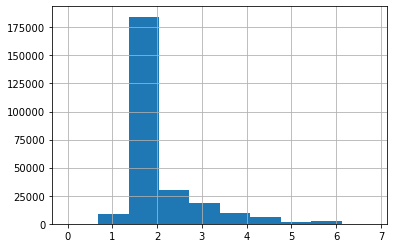

In [32]:
data_full['engineDisplacement'].hist()

В результате пребразований получен числовой признак. Распределение можно считать нормальным.

In [33]:
num_cols.append('engineDisplacement')

## 8. enginePower

- мощность двигателя, л. с.; тип данных - object

In [34]:
data_full.enginePower.value_counts()

 150 л.с.     13832
 98 л.с.       7997
 123 л.с.      7181
 81 л.с.       6765
 106 л.с.      6538
              ...  
303 N12           1
61 N12            1
 37 л.с.          1
 336 л.с.         1
 311 л.с.         1
Name: enginePower, Length: 681, dtype: int64

Проверим признак на пустые ячейки.

In [35]:
data_full.enginePower.isna().sum()

0

Посмотрим все уникальные значения признака.

In [36]:
data_full.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

Преобразуем признак из object в числовой.

In [37]:
pattern = re.compile('\d+')

data_full['enginePower'] = data_full['enginePower'].apply(lambda x: float(pattern.findall(x)[0]))

Построим гистограмму распределения признака.

<AxesSubplot:>

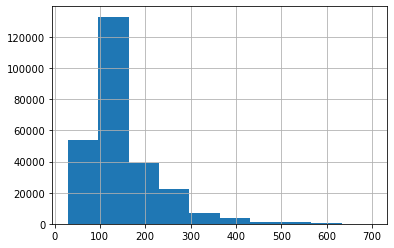

In [38]:
data_full['enginePower'].hist()

В результате пребразований получен числовой признак. Распределение можно считать нормальным.

In [39]:
num_cols.append('enginePower')

## 9. fuelType

- тип топлива; тип данных - object

In [40]:
data_full.fuelType.value_counts()

 Бензин                                199853
бензин                                  28601
 Дизель                                 22081
дизель                                   5800
 Бензин, газобаллонное оборудование      4054
 Гибрид                                  1702
гибрид                                    223
электро                                    55
 Газ, газобаллонное оборудование           27
 Газ                                       18
 Дизель, газобаллонное оборудование         9
газ                                         7
 Гибрид, газобаллонное оборудование         4
Name: fuelType, dtype: int64

Проверим признак на пустые ячейки.

In [41]:
data_full.fuelType.isna().sum()

0

Посмотрим все уникальные значения.

In [42]:
data_full.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ', ' Бензин',
       ' Дизель', ' Бензин, газобаллонное оборудование', ' Гибрид',
       ' Дизель, газобаллонное оборудование',
       ' Газ, газобаллонное оборудование', ' Газ',
       ' Гибрид, газобаллонное оборудование'], dtype=object)

Преобразуем ' Газ, газобаллонное оборудование' в ' Газ'.

In [43]:
data_full.fuelType = data_full.fuelType.apply(lambda x: 'газ' if x == ' Газ, газобаллонное оборудование' else x)

Удалим одну строку со значением '1618546594.0'.

In [44]:
data_full = data_full.drop(data_full[data_full.fuelType == '1618546594.0'].index)

Приведем все значения к нижнему регистру.

In [45]:
data_full.fuelType = data_full.fuelType.apply(lambda x: x.lower())

Приведем уникальные значения к единообразному виду.

In [46]:
pattern = re.compile('[а-я]+')

data_full.fuelType = data_full.fuelType.apply(lambda x: 'гибрид' if len(x.split(',')) == 2 else pattern.findall(x)[0])

<AxesSubplot:>

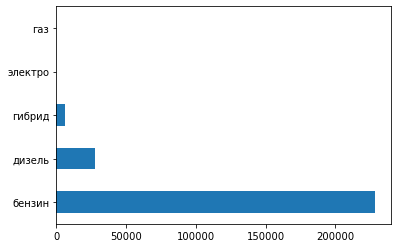

In [47]:
data_full.fuelType.value_counts().plot.barh()

В результате преобразований получен категориальный признак.

In [48]:
cat_cols.append('fuelType')

## 10. mileage

- пробег автомобиля, км; тип данных - object

In [49]:
data_full.mileage.value_counts()

200 000 км    4210
150 000 км    3620
180 000 км    2857
170 000 км    2598
160 000 км    2525
              ... 
309 393 км       1
39 130 км        1
91 480 км        1
74 657 км        1
81 761 км        1
Name: mileage, Length: 56434, dtype: int64

Проверим признак на пустые ячейки.

In [50]:
data_full.mileage.isna().sum()

0

Посмотрим на структуру значений.

In [51]:
data_full.mileage[0]

74000

In [52]:
data_full.mileage[237229]

'172\xa0000\xa0км'

Уберем части строки равные '\xa0' из всех значений признака.

In [53]:
data_full['mileage'] = data_full['mileage'].apply(lambda x: str(x).replace('\xa0', ''))

Преобразуем признак из object в числовой.

In [54]:
pattern = re.compile('\d+')

data_full['mileage'] = data_full['mileage'].apply(lambda x: int(pattern.findall(x)[0]))

Построим гистограмму распределения признака.

<AxesSubplot:>

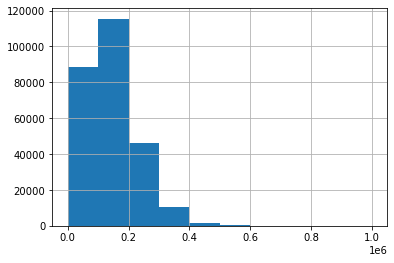

In [55]:
data_full['mileage'].hist()

В результате пребразований получен числовой признак. Распределение можно считать нормальным.

In [56]:
num_cols.append('mileage')

## 11. productionDate

- год производства автомобиля; тип данных - float

In [57]:
data_full.productionDate.value_counts()

2008.0    20101
2012.0    19082
2013.0    19021
2011.0    18557
2007.0    17407
          ...  
1952.0        1
1957.0        1
1962.0        1
1970.0        1
1904.0        1
Name: productionDate, Length: 73, dtype: int64

Проверим признак на пустые ячейки.

In [58]:
data_full.productionDate.isna().sum()

0

Посмотрим на уникальные значения.

In [59]:
data_full.productionDate.unique()

array([2014., 2017., 2012., 2011., 2019., 2018., 2010., 2020., 2016.,
       2013., 2006., 2007., 2015., 2005., 2008., 2009., 1997., 2004.,
       2002., 1987., 2003., 2001., 1976., 2000., 1998., 1995., 1999.,
       1993., 1939., 1996., 1984., 1990., 1991., 1992., 1989., 1982.,
       1985., 1994., 1938., 1981., 1988., 1983., 1980., 1986., 1978.,
       1970., 1979., 1977., 1972., 1975., 1969., 1950., 1953., 1949.,
       1937., 1959., 1968., 1936., 1904., 1974., 1967., 1961., 1960.,
       1965., 1963., 1957., 1952., 1973., 1948., 2021., 1962., 1956.,
       1958.])

Преобразуем признак из object в числовой.

In [60]:
pattern = re.compile('\d+')

data_full['productionDate'] = data_full['productionDate'].apply(lambda x: int(pattern.findall(str(x))[0]))

Построим гистограмму распределения признака.

<AxesSubplot:>

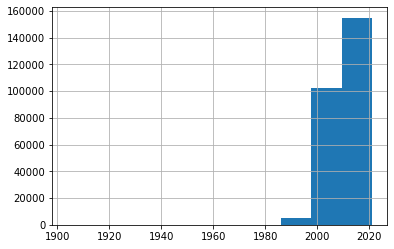

In [61]:
data_full['productionDate'].hist()

В результате пребразований получен числовой признак. На распределении визуально заметны выбросы, но они не противоречат здравому смыслу, поэтому их можно оставить.

In [62]:
num_cols.append('productionDate')

## 12. vehicleTransmission

- тип трансмиссии автомобиля; тип данных - object

In [63]:
data_full.vehicleTransmission.value_counts()

механическая        112648
автоматическая      112641
вариатор             20642
роботизированная     16503
Name: vehicleTransmission, dtype: int64

Проверим признак на пустые ячейки.

In [64]:
data_full.productionDate.isna().sum()

0

<AxesSubplot:>

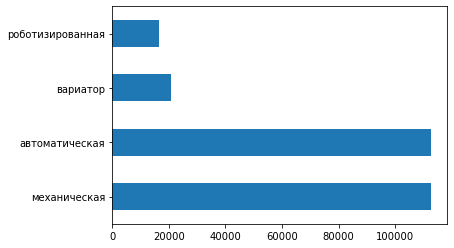

In [65]:
data_full['vehicleTransmission'].value_counts().plot.barh()

В данном признаке дополнительных преобразований не требуется. Признак является категориальным.

In [66]:
cat_cols.append('vehicleTransmission')

## 13. Владельцы

- количество владельцев автомобиля; тип данных - object

In [67]:
data_full['Владельцы'].value_counts()

3 или более    125121
1 владелец      72006
2 владельца     65307
Name: Владельцы, dtype: int64

Проверим признак на пустые ячейки.

In [68]:
data_full.productionDate.isna().sum()

0

Посмотрим на уникальные значения.

In [69]:
data_full['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

В данном столбце мы имеем категориальные значения. Преобразуем данные к презентабельному виду - заменим части строки равные '\xa0' на ' ' во всех значениях признака.

In [70]:
data_full['Владельцы'] = data_full['Владельцы'].apply(lambda x: str(x).replace('\xa0', ' '))

<AxesSubplot:>

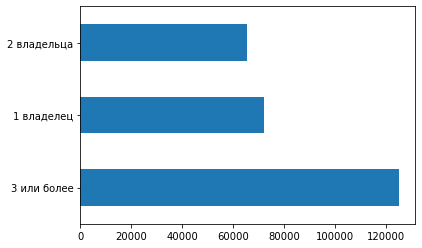

In [71]:
data_full['Владельцы'].value_counts().plot.barh()

In [72]:
cat_cols.append('Владельцы')

## 14. ПТС

- вид технического паспорта автомобиля; тип данных - object

В отчете html видим есть 1 пропуск, заполним его самым частым значением

In [73]:
data_full['ПТС'] = data_full['ПТС'].fillna(data_full['ПТС'].value_counts().head(1).index[0])

In [74]:
data_full['ПТС'].value_counts()

Оригинал    226756
Дубликат     35678
Name: ПТС, dtype: int64

<AxesSubplot:xlabel='ПТС', ylabel='count'>

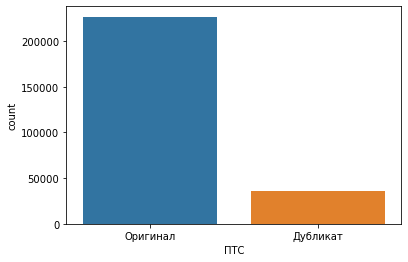

In [75]:
sns.countplot(x = 'ПТС', data = data_full)

Видно, что оригинальных ПТС намного больше, чем дубликатов.

Здесь мы имеем бинарный признак. Дополнительных преобразований не требуется.

In [76]:
bin_cols.append('ПТС')

## 15. Привод

- вид привода автомобиля, тип данных - object

In [77]:
data_full['Привод'].value_counts()

передний    164090
полный       77231
задний       21113
Name: Привод, dtype: int64

Проверим признак на ниличие пустых значений

In [78]:
data_full.Привод.isna().sum()

0

<AxesSubplot:xlabel='Привод', ylabel='count'>

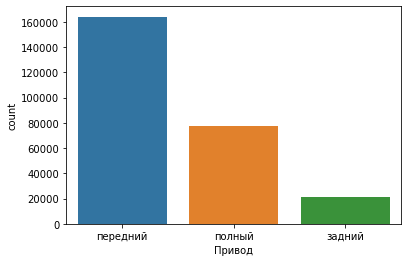

In [79]:
sns.countplot(x='Привод', data=data_full)

Признак категориальный. Дополнительная обработка не требуется

In [80]:
cat_cols.append('Привод')

## 16. Руль

расположение рулевого колеса; тип данных - object

In [81]:
data_full['Руль'].value_counts()

Левый     247922
Правый     14512
Name: Руль, dtype: int64

Проверим наличие пустых значений

In [82]:
data_full.Руль.isna().sum()

0

<AxesSubplot:xlabel='Руль', ylabel='count'>

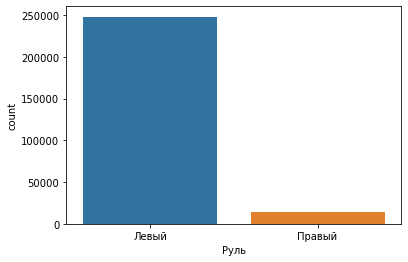

In [83]:
sns.countplot(x='Руль', data=data_full)

Признак бинарный. Дополнительная обработка не требуется

In [84]:
bin_cols.append('Руль')

## 17. Состояние

указатель необходимости ремонта автомобиля; тип данных - object

In [85]:
data_full['Состояние'].value_counts()

Не требует ремонта    262431
Битый / не на ходу         3
Name: Состояние, dtype: int64

Проверим наличие пустых значений

In [86]:
data_full.Состояние.isna().sum()

0

<AxesSubplot:xlabel='Состояние', ylabel='count'>

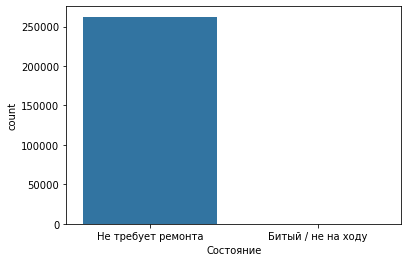

In [87]:
sns.countplot(x='Состояние', data=data_full)

Признак бинарный. Дополнительная обработка не требуется

In [88]:
bin_cols.append('Состояние')

## 18. Таможня
Признак одинаков для всех строк и не несет полезной информации. В модель не включаем.

## 19 equipment_dict
Данные этого поля дублируются в других полях датасета. Полезной информации не несет. В модель не включаем.

## 20. brand
марка автомобиля; тип данных - object

In [89]:
data_full['brand'].value_counts()

LADA (ВАЗ)       46758
Kia              17847
Hyundai          17160
Toyota           16130
BMW              15307
Nissan           13279
Mercedes-Benz    11300
Renault          10374
Ford             10239
Opel              9324
Mazda             7990
Skoda             7304
Mitsubishi        7078
Audi              6429
Honda             5465
VOLKSWAGEN        4404
NISSAN            4393
MERCEDES          4180
Peugeot           4000
TOYOTA            3913
AUDI              3421
Lexus             3214
Land Rover        2898
MITSUBISHI        2843
SKODA             2741
Volvo             2502
Subaru            2470
Chery             2385
Suzuki            2328
Citroen           2235
Lifan             2165
Infiniti          1648
Geely             1491
VOLVO             1463
Porsche           1426
ГАЗ               1227
HONDA             1150
INFINITI           871
LEXUS              834
Haval              248
Name: brand, dtype: int64

Имеются повторы. Обработаем данные

In [90]:
# приведем названия марок авто к нижнему регистру
data_full['brand'] = data_full['brand'].apply(lambda x: x.lower())

# заменим название mercedes-benz на mercedes
data_full['brand'] = data_full['brand'].apply(
    lambda x: x.replace('mercedes-benz', 'mercedes'))

Посмотрим результат

In [91]:
data_full['brand'].value_counts()

lada (ваз)    46758
toyota        20043
kia           17847
nissan        17672
hyundai       17160
mercedes      15480
bmw           15307
renault       10374
ford          10239
skoda         10045
mitsubishi     9921
audi           9850
opel           9324
mazda          7990
honda          6615
volkswagen     4404
lexus          4048
peugeot        4000
volvo          3965
land rover     2898
infiniti       2519
subaru         2470
chery          2385
suzuki         2328
citroen        2235
lifan          2165
geely          1491
porsche        1426
газ            1227
haval           248
Name: brand, dtype: int64

Признак категориальный. Дополнительная обработка не требуется.

In [92]:
cat_cols.append('brand')

## 21. model_name
модель автомобиля; тип данных - object

In [93]:
data_full['model_name'].value_counts()

Granta      7084
Focus       5651
Priora      5393
Rio         5259
Solaris     4621
            ... 
Focus RS       1
IST            1
OTTI           1
EMERAUDE       1
KIX            1
Name: model_name, Length: 1416, dtype: int64

Обработаем данные

In [94]:
# приведем значения к нижнему регистру и удажим лишние пробелы
data_full['model_name'] = data_full['model_name'].apply(
    lambda x: x.lower().strip())
data_full['model_name'].value_counts()

granta        7084
focus         5651
priora        5393
rio           5259
octavia       4813
              ... 
69               1
favorit          1
cervo            1
passport         1
efini ms-9       1
Name: model_name, Length: 1216, dtype: int64

Число уникальных значений немного уменьшилось

Признак категориальный.

In [95]:
cat_cols.append('model_name')

## 22. name
полная информация о двигателе; тип данных - object

Информация в данном поле дублирует информацию в других полях. В модель не включаем.

## 23. sample_
признак включения в тестовый датасет

## 24. price

- стоимость автомобиля. тип данных - float

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


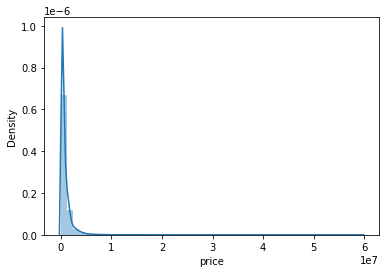

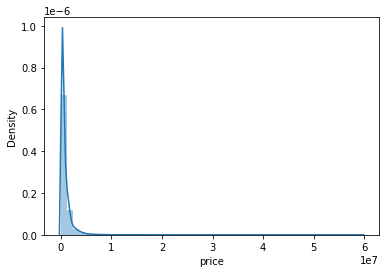

In [96]:
sns.distplot(data_full[data_full['sample_']==0]['price']).get_figure()

На распределении визуально заметны выбросы, но они не противоречат здравому смыслу, поэтому их можно оставить.

## Оставим в датасете только отобранные признаки

In [97]:
data_full = data_full[cat_cols + bin_cols + num_cols + ['price', 'sample_']]

# Обработка и анализ числовых признаков

Посмотрим на все числовые признаки.

In [98]:
data_full[data_full['sample_'] == 0][num_cols + ['price']]

,description_len,engineDisplacement,enginePower,mileage,productionDate,price
34686,155,3.0,218.0,215000,2005,545000.0
34687,538,4.1,326.0,117000,2008,1470000.0
34688,380,2.0,225.0,54500,2014,1830000.0
34689,425,2.7,250.0,200000,2004,390000.0
34690,419,3.0,239.0,225000,2010,990000.0
...,...,...,...,...,...,...
264350,334,2.4,170.0,376765,2004,300000.0
264351,162,2.5,210.0,197000,2003,385500.0
264352,1189,2.5,210.0,242000,2004,390000.0
264353,581,1.8,122.0,257000,2001,200000.0


Постороим матрицу корреляций числовых переменных друг с другом и с целевой переменной price.

<AxesSubplot:>

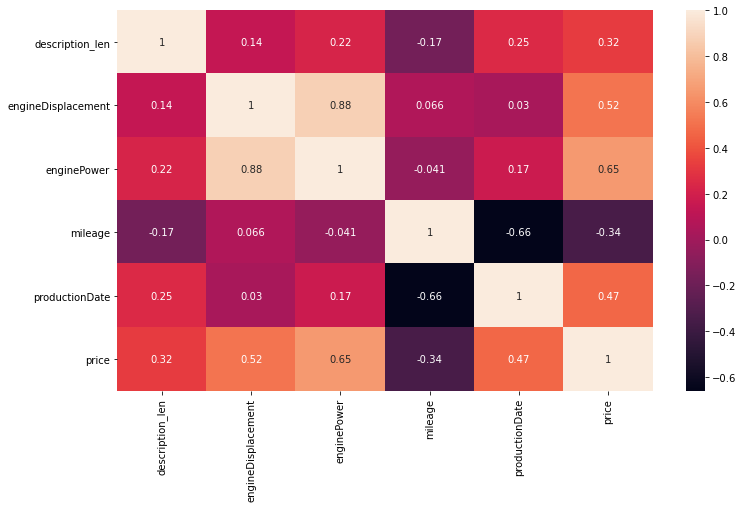

In [99]:
plt.figure(figsize=(12,7))
sns.heatmap(data_full[data_full['sample_'] == 0][num_cols + ['price']].corr(), annot=True)

Здесь мы видим, что сильную корреляцию между собой имеют признаки engineDisplacement (объем двигателя) и enginePower (мощность двигателя) - 0.88. Поэтому удаляем один признак - engineDisplacement (объем двигателя), т.к. enginePower (мощность двигателя) более презентабелен.

In [100]:
data_full = data_full.drop(['engineDisplacement'], axis = 1)

Также удалим его из списка числовых переменных num_cols.

In [101]:
num_cols = num_cols[:1] + num_cols[2:]

Наблюдается достаточно высокая корреляция между productionDate (год производства автомобиля) и mileage (пробег автомобиля) - 0.66. Но здесь можно оставить оба признака.

Корреляция среди обучающих признаков с целевой переменной price (цена автомобиля) самая высокая у enginePower (мощность двигателя) - 0.65, но мы его оставляем.

Оценим значимость числовых переменных.

<AxesSubplot:>

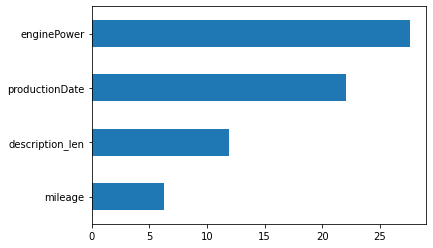

In [102]:
imp_num = Series(f_classif(data_full[num_cols][data_full['sample_'] == 0], data_full[data_full['sample_'] == 0]['price'])[0], 
                 index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Из графика видим. что наиболее важный признак для предсказания - это enginePower (мощность двигателя), а наименее - mileage (пробег автомобиля).

# Обработка и анализ бинарных признаков
Преобразуем отобранные бинарные признаки

In [103]:
label_encoder = LabelEncoder()
for column in bin_cols:
    data_full[column] = label_encoder.fit_transform(data_full[column])

Проверим, что все корректно преобразовалось

In [104]:
data_full[bin_cols].head(5)

,description_is,real_photo,ПТС,Руль,Состояние
0,0,1,1,0,1
1,0,1,1,0,1
2,0,1,1,0,1
3,0,1,1,0,1
4,0,1,1,0,1


In [105]:
for i in bin_cols:
    display(data_full[i].value_counts())

0    259872
1      2562
Name: description_is, dtype: int64

1    220990
0     41444
Name: real_photo, dtype: int64

1    226756
0     35678
Name: ПТС, dtype: int64

0    247922
1     14512
Name: Руль, dtype: int64

1    262431
0         3
Name: Состояние, dtype: int64

Посмотрим значимость

<AxesSubplot:>

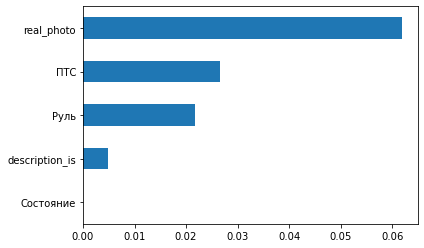

In [106]:
imp_cat = Series(mutual_info_classif(data_full[data_full.sample_ == 0][bin_cols], data_full[data_full.sample_ == 0]['price'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

На цену меньше всего влияет состояние, что противоречит здравому смыслу... Видимо сказывается несбалансированность этого признака, почти все объявления с одним значением. А самый больший вклад в цену вносит наличие реальной фотографии.

# Обработка и анализ категориальных признаков

In [107]:
#преобразование, значимость, выводы. Label encoding
data_full[cat_cols]

,bodyClass,color,fuelType,vehicleTransmission,Владельцы,Привод,brand,model_name
0,лифтбек,синий,бензин,роботизированная,3 или более,передний,skoda,octavia
1,лифтбек,чёрный,бензин,механическая,1 владелец,передний,skoda,octavia
2,лифтбек,серый,бензин,роботизированная,1 владелец,передний,skoda,superb
3,лифтбек,коричневый,бензин,автоматическая,1 владелец,передний,skoda,octavia
4,лифтбек,белый,бензин,автоматическая,1 владелец,передний,skoda,octavia
...,...,...,...,...,...,...,...,...
264350,седан,серый,бензин,автоматическая,3 или более,передний,volvo,s80
264351,универсал,серебристый,бензин,автоматическая,3 или более,полный,volvo,xc70
264352,седан,чёрный,бензин,автоматическая,3 или более,полный,volvo,s80
264353,седан,серый,бензин,автоматическая,3 или более,передний,volvo,s40


Сделаем копию датасета

In [108]:
df = data_full.copy()

Произведем Label-encoding категориальных переменных

In [109]:
label_encoder = LabelEncoder()
for column in cat_cols:
    df[column] = label_encoder.fit_transform(df[column])

Посмотрим значимость категориальных переменных

<AxesSubplot:>

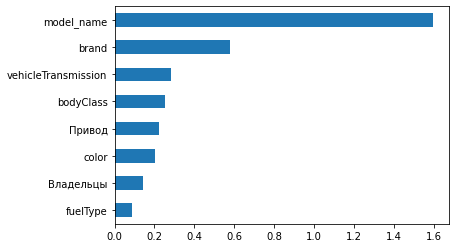

In [110]:
imp_cat = Series(mutual_info_classif(df[data_full.sample_ == 0][cat_cols], df[data_full.sample_ == 0]['price'],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Как видно из графиков, наибольшее влияние на целевую переменную оказывают марка и модель автомобиля. Большое влияние модели автомобиля обусловлено относительно небольшим числом записей для каждой модели.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения цены по различным параметрам неразличимы

In [111]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'], 
                        df.loc[df.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            
for col in cat_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки model_name


Так как число уникальных значений для поля model_name очень большое не включаем его в модель

In [112]:
cat_cols.remove('model_name')
data_full.drop(columns=['model_name'], inplace=True)

Создадим дамми переменные

In [113]:
data_full = pd.get_dummies(data_full, columns = cat_cols)

In [114]:
first_index_cat_cols = data_full.columns.to_list().index('sample_')+1
cat_cols = data_full.columns[first_index_cat_cols:].to_list()

Выгрузим данные в csv для дальнейшего обучения

In [115]:
data_full.to_csv('data_full_EDA.csv', index = False)

Выгрузим названия колонок по типам

In [116]:
df_columns = pd.DataFrame()

for col in num_cols:
    new_row = {'column_type': 'num', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)

for col in bin_cols:
    new_row = {'column_type': 'bin', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)

for col in cat_cols:
    new_row = {'column_type': 'cat', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)
    
df_columns.to_csv('data_full_columns.csv', index = False)

In [117]:
df = pd.read_csv('data_full_columns.csv')
data_full[df[df.column_type == 'cat'].column_name.values]

,bodyClass_other,bodyClass_автобус,bodyClass_внедорожник,bodyClass_грузо-пассажирский,bodyClass_лифтбек,bodyClass_седан,bodyClass_универсал,bodyClass_хэтчбек,color_бежевый,color_белый,...,brand_peugeot,brand_porsche,brand_renault,brand_skoda,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo,brand_газ
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264350,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
264351,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
264352,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
264353,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Выводы
Спарсилось очень много дублей. Спарсенные данные не везде совпадают с тестовым датасетом, пришлось делать дополнительную обработку.
В данных очень много категориальных признаков. Некоторые признаки несбалансированы.

# Что можно улучшить:
1. Тут большое поле для feature engineering, много текста из которого можно вытащить доп информацию.  
2. Задействованы далеко не все из спарсенного, т.к. некоторые спарсенные данные не совпадают с тестовыми. Можно попытаться вытащить общую информацию из того что есть, или проанализировать и подкорректировать парсинг